# Barrier option
- here, we look at
    - up barrier option (up and knock out barrier option)
    - down barrier option (down and knock out barrier option)
    - window barrier option (window end)
    - window barrier option (window start)
- (in short) barrier option = european option + additional things 
- option becomes activated (knock in)/ extinguished (knock out) when underlying touch a preset level
- class BarrierOption():
    - **downBarrier**: The price level below which the option is knocked out (becomes worthless) if it's a down-and-out option.
    - **upBarrier**: The price level above which the option is knocked out if it's an up-and-out option.
    - **barrierStart**: The time from which the barrier condition starts to apply.
    - **barrierEnd**: The time until which the barrier condition applies.
    - **underlyingOption**: The underlying EuropeanOption object that defines the payoff profile in case the barrier is not breached. 

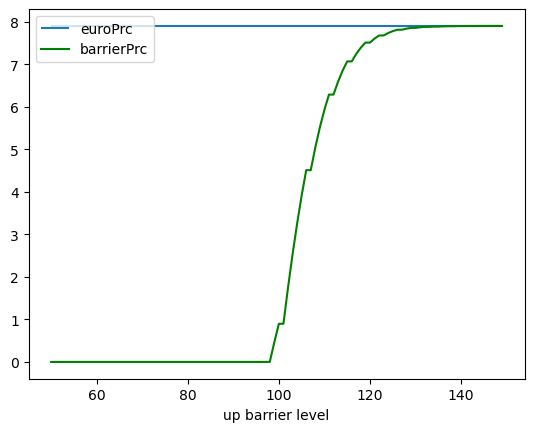

In [5]:
from enum import Enum
import math
import matplotlib.pyplot as plt
import numpy as np

class PayoffType(Enum):
    Call = 'Call'
    Put = 'Put'
    BinaryCall = 'BinaryCall'
    BinaryPut = 'BinaryPut'

class EuropeanOption(): # calc pnl of option at maturity
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType

    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)

    def valueAtNode(self, t, S, continuation):
        if continuation is None:
            return self.payoff(S)
        else:
            return continuation

def crrBinomialG(S, r, vol, trade, n): # calc initial option price 
    t = trade.expiry / n
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    vs = [trade.payoff(S * u**(n - i - i)) for i in range(n + 1)]
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            nodeS = S * u**(i - j - j)
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

class BarrierOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart 
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry

    def payoff(self, S):
        return self.underlyingOption.payoff(S)

    def valueAtNode(self, t, S, continuation):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier is not None and S > self.upBarrier:
                return 0 # up and out barrier
            elif self.downBarrier is not None and S < self.downBarrier:
                return 0 # down and out barrier
        return continuation

# varying up barrier
S, r, vol, K = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, K, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc, ks = [], range(50, 150)
for barrierLevel in ks:
    upBarrier = BarrierOption(barrierStart=0, barrierEnd=1.0, downBarrier=None, 
                              upBarrier=barrierLevel, underlyingOption=eurOpt)
    prc = crrBinomialG(S, r, vol, upBarrier, n=300)
    barrierPrc.append(prc)

plt.hlines(euroPrc, ks[0], ks[-1], label='euroPrc')
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.xlabel('up barrier level')
plt.legend()
plt.show()


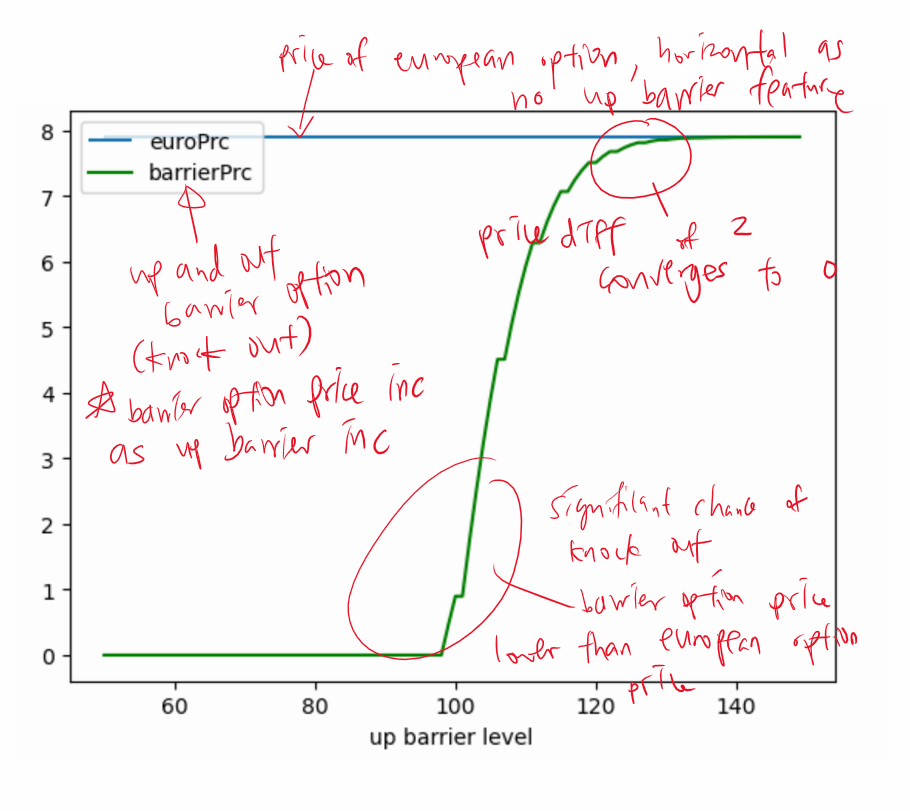

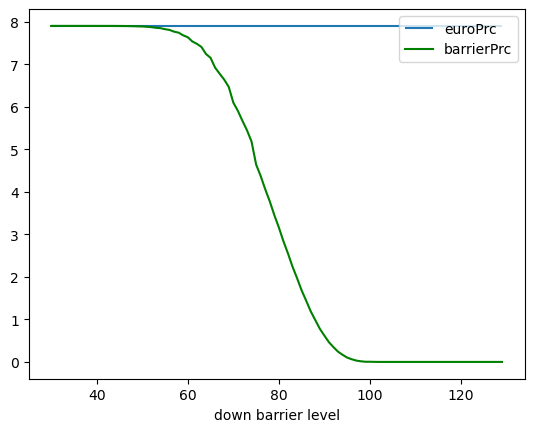

In [9]:
# varying down barrier
S, r, vol, K = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, K, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc, ks = [], range(30, 130)
for barrierLevel in ks:
    downBarrier = BarrierOption(barrierStart=0, barrierEnd=1.0, downBarrier=barrierLevel, 
                                upBarrier=None, underlyingOption=eurOpt)
    prc = crrBinomialG(S, r, vol, downBarrier, n=300)
    barrierPrc.append(prc)
plt.hlines(euroPrc, ks[0], ks[-1], label='euroPrc')
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.xlabel('down barrier level')
plt.legend()
plt.show()

## window barriers
- since this is knock out option. the barrier priod = window end - window start. and we wanat to barrier period to be shorter.

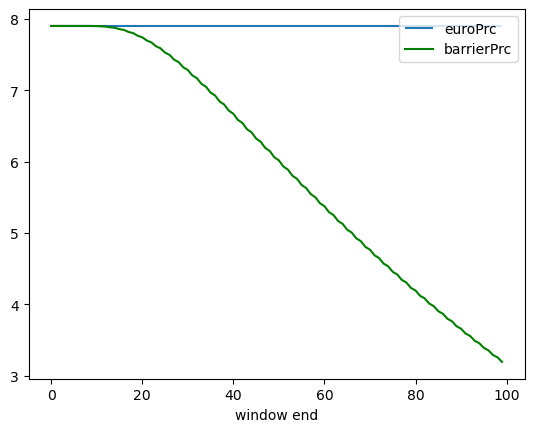

In [17]:
# varying barrier window, barrier end
S, r, vol, K = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, K, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc = []
ks = range(0, 100)
for t in ks:
    prc = crrBinomialG(S, r, vol, BarrierOption(barrierStart=0, barrierEnd=t / 100.0, downBarrier=80, 
                      upBarrier=150, underlyingOption=eurOpt), n=300)
    barrierPrc.append(prc)
plt.hlines(euroPrc, 0, max(ks), label='euroPrc')
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.legend()
plt.xlabel('window end')
plt.show()


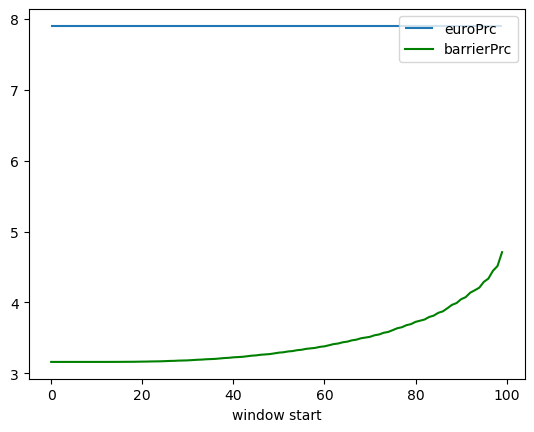

In [22]:
# varying barrier window, barrier start
S, r, vol, K = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, K, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc = []
ks = range(0, 100)
for t in ks:
    prc = crrBinomialG(S, r, vol, BarrierOption(barrierStart=t/100.0, barrierEnd=1.0, downBarrier=80, 
                      upBarrier=150, underlyingOption=eurOpt), n=300)
    barrierPrc.append(prc)
plt.hlines(euroPrc, ks[0], max(ks), label='euroPrc')  # Adjust this line as well
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.legend()
plt.xlabel('window start')
plt.show()
